In [4]:
import numpy as np
import pandas as pd
              
import matplotlib.pyplot as plt      
import matplotlib.image as mpimg                  
%matplotlib inline                              

!pip install torch
!pip install torchvision
!pip install torchsummary
import torch
import torchvision.models as models
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary
import torch.optim as optim
import os

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile, Image, ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True

from torch.utils.data.sampler import SubsetRandomSampler
from glob import glob
import numpy as np
import random
from random import shuffle

from collections import Counter

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix



You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
#!unzip Magnetic_tile_defect_datasets.zip

In [5]:
#check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available. Training on GPU ...')

CUDA is not available. Training on CPU ...


In [6]:
# define classes which are folders in main data directory with these names
classes =['Blowhole', 'Crack', 'Break', 'Fray', 'Uneven', 'Free']

#### Plot sample images and their masks

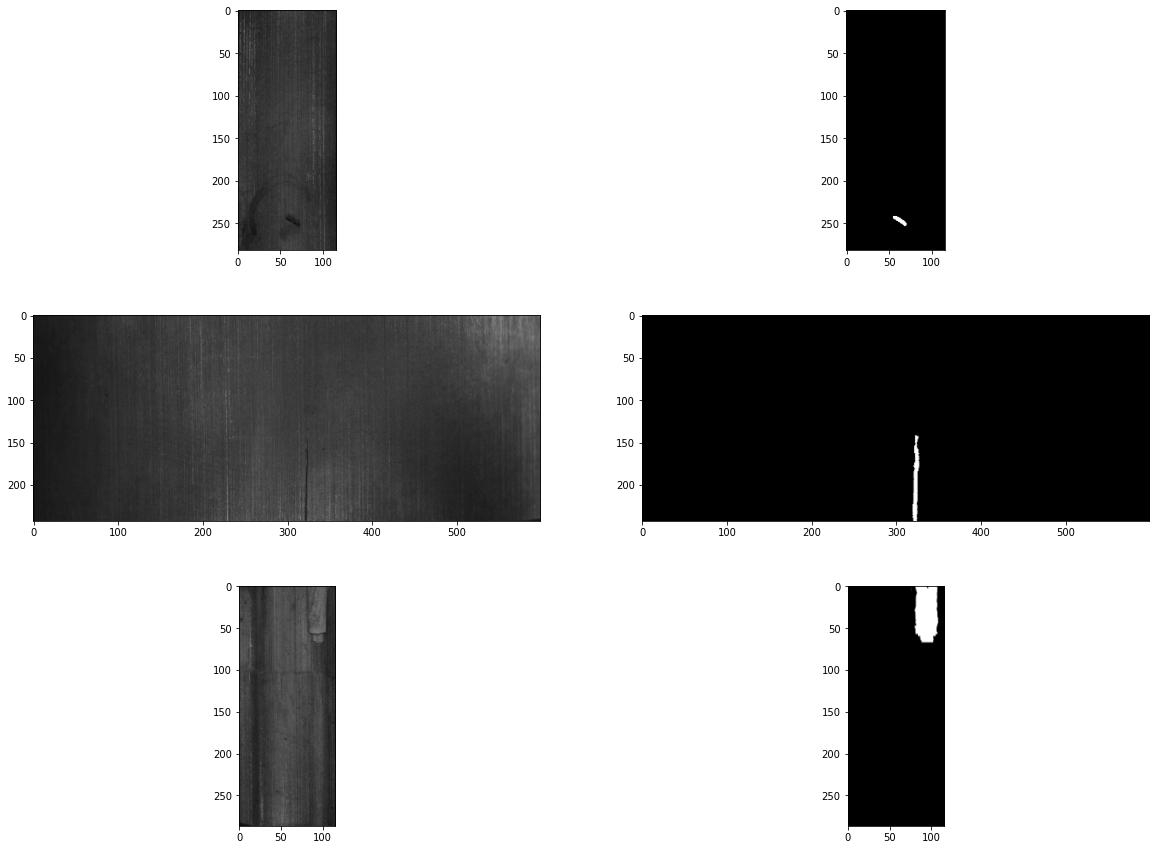

In [7]:
images_path=['data/MT_Blowhole/Imgs/exp1_num_4944','data/MT_Crack/Imgs/exp1_num_86828','/home/jovyan/work/data/MT_Break/Imgs/exp1_num_62553']

fig =  plt.figure(figsize=(20, 15))
n=len(images_path)
for i, im_path in enumerate(images_path):
    ax = fig.add_subplot(n,2,2*i+1) 
    plt.imshow(Image.open(im_path+'.jpg').convert("RGB"))
    ax = fig.add_subplot(n,2, 2*i+2)
    #plt.imshow(ImageOps.grayscale(Image.open(im_path+'.png')))
    plt.imshow(Image.open(im_path+'.png').convert("RGB"))


#### Check the number of channels

In [8]:
image = Image.open('data/MT_Blowhole/Imgs/exp1_num_4944.jpg')
mask = Image.open('data/MT_Blowhole/Imgs/exp1_num_4944.png')
print('image: ', image.size, ' ', 'mask: ', mask.size)

image:  (116, 282)   mask:  (116, 282)


In [9]:
# check the range of colors in image and mask
[[np.min(image),np.max(image)], [np.min(mask),np.max(mask)]]

[[10, 126], [0, 255]]

## Dataset

In [10]:
images_path = {}
partition = {'train':[], 'val':[], 'test':[]}
# masks={}
train = {}
val = {}
test = {}
split_ratio = [0.60, 0.20, 0.20]
for c in classes:
    images_path[c] = glob('data/MT_' + c + '/Imgs/*.jpg',recursive=True)
    random.shuffle(images_path[c])
    l = len(images_path[c])
    split_pt = [int(split_ratio[0]*l), int((split_ratio[0]+ split_ratio[1])*l)]
    print(c , ': ', l)
    train [c] = images_path[c][:split_pt[0]]
    val [c] = images_path[c][split_pt[0]: split_pt[1]]
    test [c] = images_path[c][split_pt[1]:]
    print('train: ', len(train[c]),' ','val: ', len(val[c]),' ','test: ', len(test[c]),' ','total: ',len(train[c])+len(val[c])+len(test[c]))
    partition['train'].extend(train[c])
    partition['val'].extend(val[c])
    partition['test'].extend(test[c])


Blowhole :  115
train:  69   val:  23   test:  23   total:  115
Crack :  57
train:  34   val:  11   test:  12   total:  57
Break :  85
train:  51   val:  17   test:  17   total:  85
Fray :  32
train:  19   val:  6   test:  7   total:  32
Uneven :  103
train:  61   val:  21   test:  21   total:  103
Free :  952
train:  571   val:  190   test:  191   total:  952


In [11]:
['train: ', len(partition['train']), ' ','val: ', len(partition['val']), ' ','test: ', len(partition['test'])]

['train: ', 805, ' ', 'val: ', 268, ' ', 'test: ', 271]

In [12]:
partition['train'][0]

'data/MT_Blowhole/Imgs/exp1_num_346311.jpg'

In [20]:
# tranforms

class Resize(object):
    """Resize the image to a given size. """

    def __call__(self, img, output_size ):
        """
        Args:
            img (PIL Image): Image to be resized.
            output_size (tuple): Desired output size.
        """
        assert isinstance(output_size, tuple)
        return TF.resize(img, output_size)


class Rotate(object):
    """Rotate the image by the given angle."""

    def __call__(self, img, angle):
        """
        Args:
            img (PIL Image): Image to be converted to grayscale.
            angle: Desired rotation angle in degrees
        """
        return TF.rotate(img, angle)


class VerticalFlip(object):
    """Vertically flip the image."""

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be flipped.
        """
        return TF.vflip(img)

class HorizontalFlip(object):
    """Horizontally flip the image."""

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be flipped.
        """
        return TF.hflip(img)

class Normalize(object):
    """Convert the color range of a grayscale image to [0,1] and normalize it using mean and standard deviation."""        

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be normalized.
        """
        # scale colour range from [0, 255] to [0, 1]
        img = img.astype(np.float32)/255

        # compute the mean and standard deviation of the image
        return TF.normalize(img, np.mean(img), np.std(img))
        

class ToTensor(object):
    """Convert ndarrays in to Tensors."""

    def __call__(self,img):
        """
        Args:
            img (PIL Image): Image to be converted to tensor.
        """
        return TF.ToTensor(img)  

In [19]:
from my_classes.transforms import Resize, Rotate, VerticalFlip, HorizontalFlip, Normalize, ToTensor
from my_classes.dataset import SurfaceDefectDetectionDataset
from my_classes.loss import focal_loss
from my_classes.unet import UNet

TypeError: module() takes at most 2 arguments (3 given)

In [24]:
from torch.utils.data import Dataset, DataLoader
#from my_classes.transforms import Resize, Rotate, HorizontalFlip, VerticalFlip, Normalize, ToTensor

class SurfaceDefectDetectionDataset(Dataset):
    
    def __init__(self, images_path_list):
        """
        Args:
            images_path_list: list of image files path
            transform (callable): transform to be applied on a sample.
        """
        self.images_path_list = images_path_list

    def transform(self, image, mask):
        # Resize
        image = Resize(image, (224,224))
        mask = t (mask, (224,224))

        # Random horizontal flipping
        if random.random() > 0.5:
            image = HorizontalFlip(image)
            mask = HorizontalFlip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = VerticalFlip(image)
            mask = VerticalFlip(mask)

        # Rotate
        angle = random.choice([0, -90, 90, 180])
        image = Rotate(image, angle)
        mask = Rotate (mask, angle)
 
        # Normalize
        image = Normalize(image)
        mask = mask.astype(np.float32)/255
       
        # Transform to tensor
        image = ToTensor(image)
        mask = ToTensor(mask)
        return image, mask    

    def __len__(self):
        return len(self.images_path_list)

    def __getitem__(self, idx):
               
        image = Image.open(images_path_list[idx]).convert("RGB")
        mask = Image.open(os.path.splitext(images_path_list[idx])[0]+'.png').convert("RGB")
    
        image, mask = transform(image, mask)

        return image, mask

#### Test out some transforms


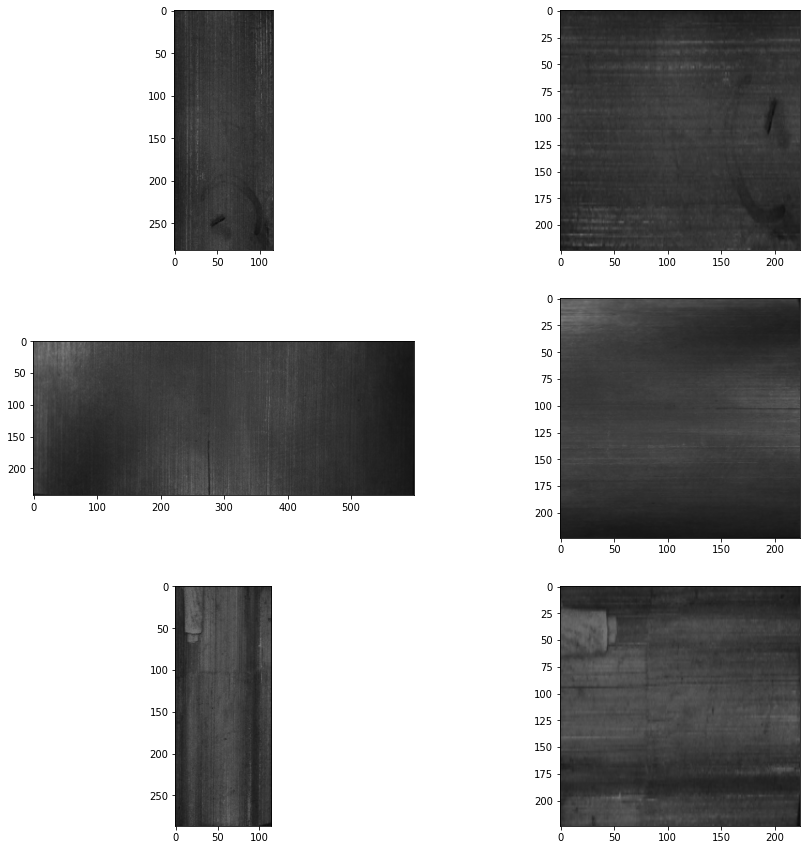

In [26]:
images_path=['data/MT_Blowhole/Imgs/exp1_num_4944',
            'data/MT_Crack/Imgs/exp1_num_86828',
            '/home/jovyan/work/data/MT_Break/Imgs/exp1_num_62553']

fig =  plt.figure(figsize=(15, 15))
n=len(images_path)
for i, im_path in enumerate(images_path):
    image = Image.open(images_path[i]+'.jpg').convert("RGB")
    mask = Image.open(images_path[i]+'.png').convert("RGB")
    t1 = HorizontalFlip()
    t2 = Resize()
    t3 = Rotate()
    ax1 = fig.add_subplot(n,2,2*i+1) 
    plt.imshow(t1(image))
    ax2 = fig.add_subplot(n,2, 2*i+2)
    plt.imshow(t3(t2(image, (224,224)),90))


### Construct the transformed dataset

In [27]:
# Construct the dataset
surface_defect_dataset ={}
for p in ['train', 'val', 'test']:
    surface_defect_dataset[p] = SurfaceDefectDetectionDataset(partition[p])

# print some stats about the dataset
print('Length of dataset: ', len(surface_defect_dataset))
print('Length of train dataset: ', len(surface_defect_dataset['train']))
print('Length of validation dataset: ', len(surface_defect_dataset['val']))
print('Length of test dataset: ', len(surface_defect_dataset['test']))
surface_defect_dataset['test']

Length of dataset:  3
Length of train dataset:  805
Length of validation dataset:  268
Length of test dataset:  271


### Batch and load data

In [28]:
# CUDA for PyTorch
device = torch.device("cuda" if train_on_gpu else "cpu")
torch.backends.cudnn.benchmark = True

# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}
max_epochs = 100

# Generators
training_generator = torch.utils.data.DataLoader(surface_defect_dataset['train'], **params)
validation_generator = torch.utils.data.DataLoader(surface_defect_dataset['val'], **params)

## Training

### Specify the loss function and optimizer

In [ ]:
from loss import FocalLoss
import torch.optim as optim

criterion = FocalLoss()

optimizer = optim.Adam(net.parameters())
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train and validate the model